可以对内容进行简化和修改，使其更易于理解。以下是对内容的重新组织、补充说明和简化的版本：

---

# 图像恢复的运算过程

图像恢复的目的是从退化的图像中还原出尽量接近原始图像的结果。我们从退化过程的数学模型出发，总结了恢复的基本过程：

## 空间域恢复

图像退化通常可以描述为以下公式：

$$
\left \{ \begin{matrix} 
g(x, y) = h(x, y) \odot f(x, y) + \eta(x, y) \\ 
\hat f(x, y) = \omega(x, y) * g(x, y) - \eta(x, y) 
\end{matrix} \right.
$$

其中：
- \( g(x, y) \) 为退化后的图像；
- \( h(x, y) \) 为退化函数；
- \( f(x, y) \) 为原始图像；
- \( \eta(x, y) \) 为噪声；
- \( \omega(x, y) \) 为恢复函数。

**退化过程**：退化函数 \( h(x, y) \) 和原图像 \( f(x, y) \) 卷积，并加入噪声 \( \eta(x, y) \)，得到退化图像 \( g(x, y) \)。

**恢复过程**：应用恢复函数 \( \omega(x, y) \) 到 \( g(x, y) \)，希望得到原始图像 \( f(x, y) \)。

一般来说，恢复函数 \( \omega(x, y) \) 不一定是退化函数的反运算。

## 频域恢复

在频域下，恢复过程可简化为：

$$
\left \{ \begin{matrix} 
G(u, v) = H(u, v) \cdot F(u, v) + D(u, v) \\ 
\hat F(u, v) = G(u, v) \cdot H(u, v)^{-1} - D(u, v) 
\end{matrix} \right.
$$

在频域中，只要知道 \( H(u, v) \) 的逆函数，就可以恢复图像。

---

# 自适应滤波：最小均方差滤波

当 \( H(u, v) \) 未知时，我们可以使用**自适应滤波方法**进行恢复，其中「最小均方差滤波」（Least Mean Square Filter, LMS Filter）是一种常用的自适应滤波方法。LMS 滤波通过最小化恢复图像与原始图像的误差均方值来调整滤波器系数，逐步逼近理想的恢复效果。

## 基本原理

LMS 滤波使用**梯度下降法**调整滤波器系数，以便最小化误差信号的均方值。其核心思想是通过计算误差与原始图像的差距，不断更新权重，使得恢复效果更好。

1. **误差计算**：误差的均方值可以表示为：

   $$
   E\{ e^2(n) \} = \{\hat F(n) - F(n) \} ^2
   $$

2. **权重更新公式**：

   权重更新基于梯度下降算法：

   $$
   \hat \omega = \omega - \lambda \nabla (e^2)
   $$

   其中 \( \lambda \) 是学习率，用于控制权重更新的幅度。梯度的正负决定了权重更新的方向，从而逐渐逼近最佳权重。

---

## LMS 滤波实现步骤

具体步骤如下：

1. **初始化**：将图像 \( f(x, y) \) 和退化图像 \( g(x, y) \) 转换到频域 \( F(u, v) \) 和 \( G(u, v) \)；
2. **初始化权重**：生成一个与 \( G(u, v) \) 同尺寸的权重矩阵 \( W(u, v) \)；
3. **设置学习率** \( \lambda \)：通常为小于 1 的浮点数；
4. **迭代更新**：
   - 根据权重矩阵 \( W(u, v) \) 计算恢复图像 \( \hat F(u, v) \)；
   - 计算当前误差 \( MSE \)；
   - 更新权重矩阵 \( W \)，重复上一步直到误差收敛或达到最大迭代次数。

## 代码实现示例

以下是 LMS 滤波的代码示例，逐步逼近理想的图像恢复效果：

In [1]:
import numpy as np

# LMS 滤波函数
def lms_filter(G, F, learning_rate=0.01, max_iters=100):
    # 初始化权重矩阵
    W = np.random.randn(*G.shape)
    errors = []

    for i in range(max_iters):
        # 计算当前恢复的图像
        F_hat = G * W
        # 计算均方误差 (MSE)
        error = np.mean((F - F_hat)**2)
        errors.append(error)

        # 计算误差梯度
        gradient = -2 * (F - F_hat) * G
        # 更新权重
        W -= learning_rate * gradient

        # 提前停止条件
        if error < 1e-6:
            break

    return F_hat, W, errors



在上述代码中：
- `G` 是退化图像，`F` 是原始图像；
- `learning_rate` 控制权重更新的速度；
- 迭代更新权重 `W`，直到误差降到设定的阈值。

--- 

通过「最小均方差滤波」，即便在不完全了解退化函数的情况下，仍然可以在一定程度上恢复图像。

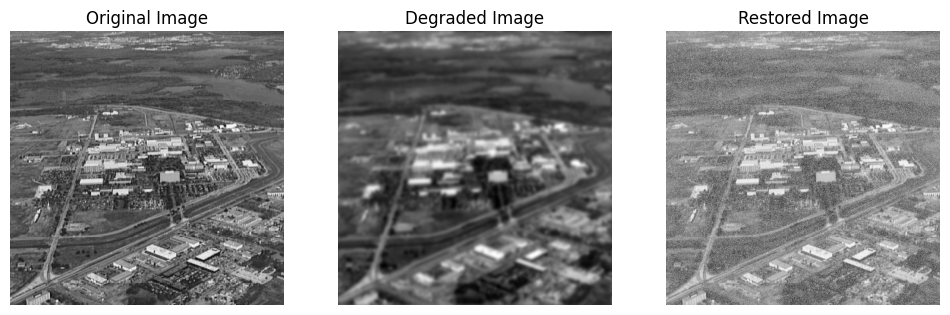

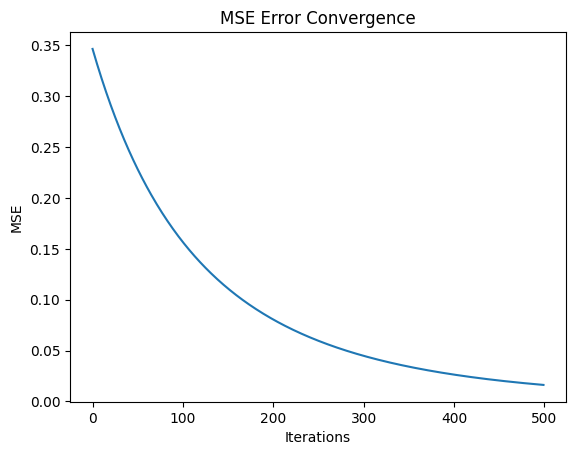

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# 图像归一化函数
def normalize_image(img):
    return img / 255.0

# 图像路径
BASE_DIR = "/opt/images/DIPRawImageDataset/DIP3E_CH05_Original_Images/DIP3E_CH05_Original_Images"

# 加载图像
original_img = cv2.imread(os.path.join(BASE_DIR, "Fig0525(a)(aerial_view_no_turb).tif"), cv2.IMREAD_GRAYSCALE)
degraded_img = cv2.imread(os.path.join(BASE_DIR, "Fig0525(b)(aerial_view_turb_c_0pt0025).tif"), cv2.IMREAD_GRAYSCALE)

# 图像归一化
original_img = normalize_image(original_img)
degraded_img = normalize_image(degraded_img)

# 应用 LMS 滤波器
restored_img, _, errors = lms_filter(degraded_img, original_img, learning_rate=0.01, max_iters=500)

# 显示结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Degraded Image")
plt.imshow(degraded_img, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Restored Image")
plt.imshow(restored_img, cmap='gray')
plt.axis("off")

plt.show()

# 显示误差收敛情况
plt.figure()
plt.plot(errors)
plt.title("MSE Error Convergence")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()